In [444]:
import numpy
from airfoil_helper import *
from matplotlib import pyplot
%matplotlib inline

In [445]:
# add freestream velocity and AOA 
u_inf, alpha = 1.0, 4.0
freestream = Freestream(u_inf, alpha)

In [446]:
x_m_ends, y_m_ends = numpy.loadtxt('resources/NACA23012_MainFoil.csv', delimiter=',', unpack=True)
x_f_ends, y_f_ends = numpy.loadtxt('resources/NACA23012_FlapFoil.csv', delimiter=',', unpack=True)

In [447]:
x_h ,y_h = 1.03, -0.054

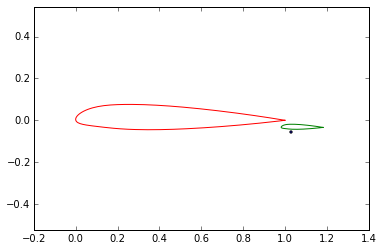

In [448]:
pyplot.plot(x_m_ends, y_m_ends, 'r-', x_f_ends,y_f_ends, 'g-')
pyplot.axis('equal')
pyplot.scatter(x_h,y_h, s=5);

In [449]:
def rotate(x,y,x_c,y_c, angle):
    r = numpy.sqrt((x-x_c)**2 + (y-y_c)**2)
    theta = numpy.arccos((x-x_c)/r)
    theta_new = theta - float(angle)/180.*numpy.pi
    x_new = x_c + r*numpy.cos(theta_new)
    y_new = y_c + r*numpy.sin(theta_new)
    return x_new, y_new

In [450]:
x_f_new, y_f_new = rotate(x_f_ends, y_f_ends, x_h,y_h,15)

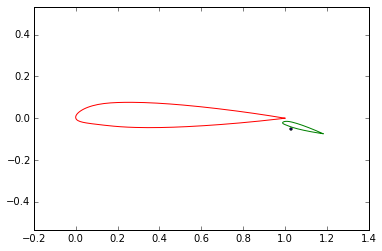

In [451]:
pyplot.plot(x_m_ends, y_m_ends, 'r-', x_f_new,y_f_new, 'g-')
pyplot.axis('equal')
pyplot.scatter(x_h,y_h, s=5);

In [452]:
def gen_panels(x_ends, y_ends):
    N = len(x_ends) - 1  
    panels = numpy.empty(N, dtype=object)
    for i in xrange(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    return panels

In [453]:
mains, flaps = gen_panels(x_m_ends, y_m_ends), gen_panels(x_f_new, y_f_new)
panels = numpy.concatenate((mains, flaps))

In [454]:
def source_matrix(panels):
    """build the N*N source coefficient matrix"""
    a = numpy.zeros((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(a, 0.5)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i!=j:
                a[i, j] = 0.5/numpy.pi*integral(p_i, p_j, p_i.nx, p_i.ny)
    return a

In [455]:
def vortex_array(panels):
    """return N*2 vortex coefficient array"""
    N = panels.size
    mains = panels[:N/2]
    flaps = panels[N/2:]
    a = numpy.zeros((N, 2), dtype=float)
    # loop in evaluation panel i
    for i, p_i in enumerate(panels):
        # loop in main airfoil panel j
        for j, p_j in enumerate(mains):
            if i != j:    # jump if i,j are the same panel
                a[i, 0] -= 0.5/numpy.pi*integral(p_i, p_j, p_i.ny, - p_i.nx)
        # loop in flap airfoil panel j
        for j, p_j in enumerate(flaps):
            if i != (j+N/2):    # jump if i,j are the same panel
                a[i, 1] -= 0.5/numpy.pi*integral(p_i, p_j, p_i.ny, - p_i.nx)
    return a

In [456]:
def kutta_array(panels, a, b):
    """return N+2 x 1 array for main airfoil"""
    p_a, p_b = panels[a], panels[b]
    N = panels.size
    mains = panels[:N/2]
    flaps = panels[N/2:]
    A = numpy.zeros(N+2, dtype=float)
    
    # calculate the coefficient of source strength
    for j, p_j in enumerate(panels):
        if j != a:
            A[j] += 0.5/numpy.pi * integral(p_a, p_j, p_a.tx, p_a.ty)
        if j != b:
            A[j] += 0.5/numpy.pi * integral(p_b, p_j, p_b.tx, p_b.ty)
    
    # calculate the coefficient of vortex strength
    # if a,b on main airfoil
    if b <= N/2-1:
        # main airfoil
        for j, p_j in enumerate(mains):
            if j != a:
                A[-2] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            else:
                A[-2] -= 0.5
            if j != b:
                A[-2] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
            else:
                A[-2] -= 0.5
        # flap airfoil
        for j, p_j in enumerate(flaps):
            A[-1] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            A[-1] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
    
    # if a,b on flap airfoil
    elif a >= N/2:
        # main airfoil
        for j, p_j in enumerate(mains):
            A[-2] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            A[-2] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
        # flap airfoil
        for j, p_j in enumerate(flaps):
            if (j+N/2) != a:
                A[-1] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            else:
                A[-1] -= 0.5
            if (j+N/2) !=b :
                A[-1] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
            else:
                A[-1] -= 0.5
    return A

In [457]:
def build_matrix(panels):
    N = panels.size
    A = numpy.empty((N+2, N+2), dtype=float)
    AS = source_matrix(panels)
    av = vortex_array(panels)
    k1 = kutta_array(panels, 0, N/2-1)
    k2 = kutta_array(panels, N/2, N-1)
    
    A[:N, :N] = AS[:,:]
    A[:N, N:] = av[:,:]
    A[-2, :] = k1[:]
    A[-1, :] = k2[:]
    
    return A

In [458]:
A = build_matrix(panels)

In [459]:
def build_rhs(panels, freestream):
    N = panels.size
    b = numpy.zeros(N+2, dtype=float)
    for i, p_i in enumerate(panels):
        b[i] = - freestream.u_inf * numpy.cos(freestream.alpha - p_i.beta)
    # kutta condition main airfoil    
    b[-2] = -freestream.u_inf * (numpy.sin(freestream.alpha-panels[0].beta)
                               + numpy.sin(freestream.alpha-panels[N/2-1].beta))
    # kutta condition flap airfoil
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha-panels[N/2].beta)
                               + numpy.sin(freestream.alpha-panels[N-1].beta))
    return b

In [460]:
b = build_rhs(panels, freestream)

In [461]:
# calculates the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print '--> sum of source/sink strengths:', accuracy

--> sum of source/sink strengths: 0.0


In [462]:
# solves the linear system
solution = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = solution[i]
gamma_m, gamma_f = solution[-2], solution[-1]

In [463]:
def tan_vel(panels, freestream, solution):
    """Calculate the tangential velocity for each panel"""
    N = len(panels)
    mains = panels[:N/2]
    flaps = panels[N/2:]
    A = numpy.zeros((N, N+2), dtype=float)
    b = numpy.zeros(N, dtype=float)
    for i, p_i in enumerate(panels):
        # freestream
        b[i] = freestream.u_inf * numpy.sin(freestream.alpha-p_i.beta)
        # source
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi *integral(p_i, p_j, p_i.tx, p_i.ty)
        # vortex
        # i on main
        if i < N/2:
            # main wing contribution
            for j, p_j in enumerate(mains):
                if i != j:
                    A[i, -2] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
                else:
                    A[i, -2] -= 0.5
            # flap wing contribution
            for j, p_j in enumerate(flaps):
                A[i, -1] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
        # i on flap
        else:
            # main wing contribution
            for j, p_j in enumerate(mains):
                A[i,-2] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
            # flap contribution
            for j, p_j in enumerate(flaps):
                if i != (j+N/2):
                    A[i,-1] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
                else:
                    A[i,-1] -= 0.5
    
    vt = numpy.dot(A, solution) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [464]:
tan_vel(panels, freestream, solution)

In [465]:
def eval_cp(panels, freestream):
    for panel in panels:
        panel.cp = 1 - (panel.vt/freestream.u_inf)**2

In [466]:
eval_cp(panels,freestream)

In [467]:
def eval_ld(panels):
    L = 0.
    D = 0.
    for panel in panels:
        L -= panel.cp*panel.length*panel.ny
        D += panel.cp*panel.length*panel.nx
    return L, D

In [468]:
Lift, Drag = eval_ld(panels)
print "Lift     Drag"
print Lift, Drag

Lift     Drag
1.74566935538 0.122090812293


#### bisect to get aoa using script

-11 -10

-11 -10.5

-11 -10.75

-11 -10.875

-11 -10.9375

-10.96875

#### bisect to get flap angle using script

-5 -3

-0.0292849385314 0.0906368512358

-5 -4.0

-0.0292849385314 0.030582254119

-4.5

In [473]:
1- 1/numpy.sqrt(1.12804894952/0.824359758886)

0.14514113635548298

In [474]:
1- 1/numpy.sqrt(1.43522694191/0.824359758886)

0.24212409015714498

In [475]:
1- 1/numpy.sqrt(1.74566935538/0.824359758886)

0.3128091032748529

In [469]:
%%javascript
IPython.load_extensions('IPython-notebook-extensions-3.x/usability/codefolding/main');

<IPython.core.display.Javascript object>